In [160]:
import numpy as np
import glob
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.signal import freqz, resample, welch, butter, freqz_sos
from scipy.signal.windows import flattop

In [161]:
# Parameters
path_str = r"C:/Users/RenartLab/Desktop/cdc-speaker-calibration/output/251006_173825"
path = Path(path_str)
chirp_duration = 15
noise_duration = 10
fs_sc = 192000
fs_adc = 250000
time_cons = 0.005
reference_pressure = 0.00002

In [162]:
def fft_welch(
    signal: np.ndarray,
    fs: float,
    time_cons: float,
    win=None,
):
    window = flattop(int(time_cons * fs), sym=False)
    win_sum_squared = np.sum(window**2)
    win_sum = np.sum(window)

    _freq, fft = welch(
        signal,
        fs=fs,
        window=window,
    )

    power_spectrum = fft * (fs * win_sum_squared / 2)
    power_spectrum[0] *= 2

    if signal.size % 2 == 0:
        power_spectrum[-1] *= 2

    abs_y_win = np.sqrt(power_spectrum)

    _fft = (2 / win_sum) * abs_y_win

    return _freq, _fft

## EQ Filter

C:\Users\RenartLab\AppData\Local\Temp\ipykernel_14140\208418943.py:15: RuntimeWarning: divide by zero encountered in log10
  plt.plot(w, 20 * np.log10(h) + 40, color="black")
C:\Users\RenartLab\AppData\Local\Temp\ipykernel_14140\208418943.py:15: RuntimeWarning: invalid value encountered in multiply
  plt.plot(w, 20 * np.log10(h) + 40, color="black")


(-120.0, 60.0)

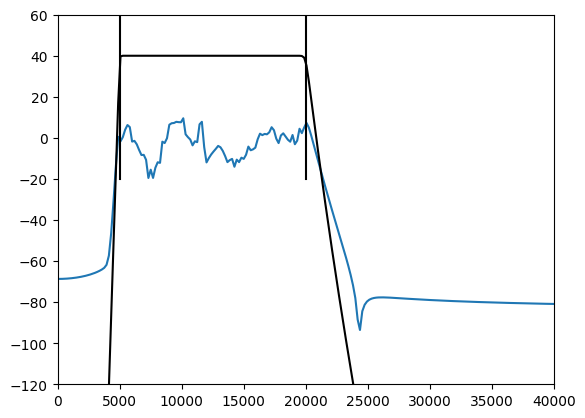

In [163]:
eq_filter = np.load(path / "eq_filter.npy")
freq, response = freqz(eq_filter, 1, fs=fs_sc)
plt.plot(freq, 20 * np.log10(response))
plt.plot([5000, 5000], [-20, 80], color="black")
plt.plot([20000, 20000], [-20, 80], color="black")

sos = butter(
    64,
    [5000, 20000],
    btype="bandpass",
    output="sos",
    fs=192000,
)
w, h = freqz_sos(sos, fs=192000)
plt.plot(w, 20 * np.log10(h) + 40, color="black")

plt.xlim(0, 40000)
plt.ylim(-120, 60)

## Calibration Sounds Frequency Spectrum

(0.0, 30000.0)

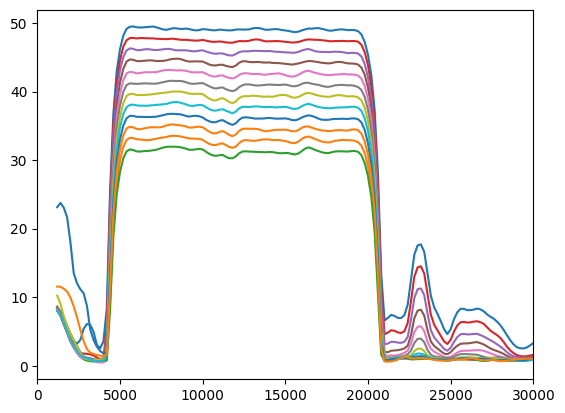

In [ ]:
# Define the file pattern
file_pattern = "/sounds/calibration_sound_{number}_rec.npy"

# Find all files that match the pattern
files = glob.glob(path_str + file_pattern.format(number="*"))

# Loop through the files and read them into numpy arrays
for file in files:
    noise = np.load(file)
    noise = resample(noise[:, 1], int(noise_duration * fs_sc))
    freq, fft = fft_welch(noise, fs=fs_sc, time_cons=time_cons)

    fft = fft[freq > 1000]
    freq = freq[freq > 1000]
    plt.plot(freq, 20 * np.log10(fft / reference_pressure))


plt.xlim(0, 30000)

In [ ]:
left_path = r"C:/Users/RenartLab/Desktop/cdc-speaker-calibration/output/251006_171854_setup8_left_speaker"
right_path = r"C:/Users/RenartLab/Desktop/cdc-speaker-calibration/output/251006_173825_setup8_right_speaker"
left_cal = np.load(left_path + "/calibration_parameters.npy")
right_cal = np.load(right_path + "/calibration_parameters.npy")

left_db = 52
right_db = 68

left_att = -20 * (left_db - left_cal[1]) / left_cal[0]
right_att = -20 * (right_db - right_cal[1]) / right_cal[0]
print(left_att, right_att)
print(left_cal)
print(right_cal)

0.5184911519150539 16.73110026650077
[19.85676776 68.51477792]
[19.81238674 68.57415145]


# Test Sounds

(0.0, 30000.0)

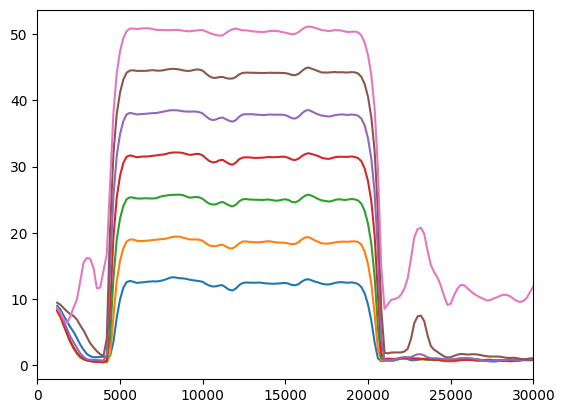

In [166]:
# Define the file pattern
file_pattern = "/sounds/test_sound_{number}_rec.npy"
test_duration = 10
mic_factor = 0.41887

# Find all files that match the pattern
files = glob.glob(path_str + file_pattern.format(number="*"))

measured_dbs = np.zeros(len(files))
i = 0

# Loop through the files and read them into numpy arrays
for file in files:
    noise = np.load(file)

    # Calculate dB
    noise2 = noise[int(0.1 * noise[:, 1].size) : int(0.9 * noise[:, 1].size), 1]
    signal_pascal = noise2 / mic_factor
    rms = np.sqrt(np.mean(signal_pascal**2))
    measured_dbs[i] = 20 * np.log10(rms / reference_pressure)
    i += 1

    noise = resample(noise[:, 1], int(test_duration * fs_sc))
    freq, fft = fft_welch(noise, fs=fs_sc, time_cons=time_cons)

    fft = fft[freq > 1000]
    freq = freq[freq > 1000]
    plt.plot(freq, 20 * np.log10(fft / reference_pressure))

plt.xlim(0, 30000)


ValueError: x and y must have same first dimension, but have shapes (5,) and (7,)

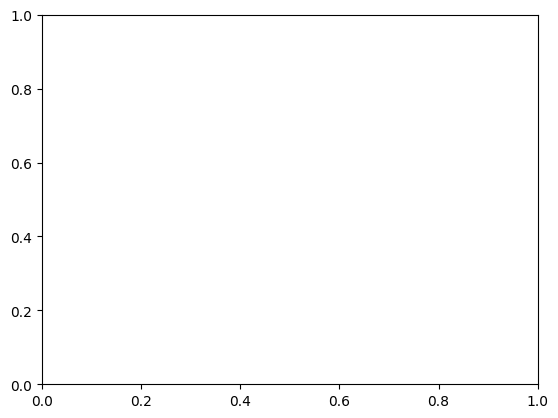

In [167]:
db_test = np.linspace(30, 65, 5)

plt.plot(db_test, measured_dbs, "o", color="blue")
plt.plot(db_test, db_test, "--", color="blue")


In [ ]:
print(np.log10(0.8))

-0.09691001300805639
